In [1]:
# Logistic Regression on Diabetes Dataset
from random import seed
from random import randrange
from random import shuffle
from csv import reader
from math import exp
import numpy as np
import time
# from multiprocessing import Pool
from multiprocessing import Pool as ThreadPool


# Load a CSV file
def load_csv(filename):
    dataset = list()
    with open(filename, 'r') as file:
        csv_reader = reader(file)
        for row in csv_reader:
            if not row:
                continue
            dataset.append(row)
    return dataset

# Convert string column to float
def str_column_to_float(dataset, column):
    for row in dataset:
        row[column] = float(row[column].strip())

# Find the min and max values for each column
def dataset_minmax(dataset):
    minmax = list()
    for i in range(len(dataset[0])):
        col_values = [row[i] for row in dataset]
        value_min = min(col_values)
        value_max = max(col_values)
        minmax.append([value_min, value_max])
    return minmax

# Rescale dataset columns to the range 0-1
def normalize_dataset(dataset, minmax):
    for row in dataset:
        for i in range(len(row)):
            row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])

# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
    folds = cross_validation_split(dataset, n_folds)
    scores = list()
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        predicted = algorithm(train_set, test_set, *args)
        actual = [row[-1] for row in fold]
        accuracy = accuracy_metric(actual, predicted)
        scores.append(accuracy)
    return scores

# Make a prediction with coefficients
def predict(row, coefficients):
    yhat = coefficients[0]
    for i in range(len(row)-1):
        yhat += coefficients[i + 1] * row[i]
    return 1.0 / (1.0 + exp(-yhat))

# Estimate logistic regression coefficients using stochastic gradient descent
def coefficients_sgd(train, l_rate, n_epoch, coef = None):
    if coef==None:
        coef = [0.0 for i in range(len(train[0]))]
    for epoch in range(n_epoch):
        for row in train:
            yhat = predict(row, coef)
            error = row[-1] - yhat
            coef[0] = coef[0] + l_rate * error * yhat * (1.0 - yhat)
            for i in range(len(row)-1):
                coef[i + 1] = coef[i + 1] + l_rate * error * yhat * (1.0 - yhat) * row[i]
    return coef
    

# Linear Regression Algorithm With Stochastic Gradient Descent
def logistic_regression(train, test, l_rate, n_epoch):
    predictions = list()
    coef = coefficients_sgd(train, l_rate, n_epoch)
    # coef = distributed_coefficients_sgd(train, l_rate, n_epoch, num_workers=8)
    for row in test:
        yhat = predict(row, coef)
        yhat = round(yhat)
        predictions.append(yhat)
    return(predictions)

# Test the logistic regression algorithm on the diabetes dataset
seed(1)
# load and prepare data
filename = 'pima-indians-diabetes.csv'
dataset = load_csv(filename)
for i in range(len(dataset[0])):
    str_column_to_float(dataset, i)
# normalize
minmax = dataset_minmax(dataset)
normalize_dataset(dataset, minmax)

# evaluate algorithm
n_folds = 10
l_rate = 0.1
n_epoch = 1000
start = time.process_time() 
scores = evaluate_algorithm(dataset, logistic_regression, n_folds, l_rate, n_epoch)
elapsed = (time.process_time() - start)
print("Time used:",elapsed)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

AttributeError: 'float' object has no attribute 'shape'

In [45]:
import random

import numpy as np

np.random.seed(seed=1)

class FixedStepSizeSelector:
    def __init__(self, step_size):
        self.step_size = step_size

    def calc_step_size(self, loss_func, grad_func, cur_loss, cur_grad, params_to_solve):
        return self.step_size


class BacktrackingStepSizeSelector:
    def __init__(self, step_size_min_reduction_relative_to_grad=0.3, step_size_reduction_factor=0.5,
                 initial_step_size=2.0):
        self.step_size = initial_step_size
        self.step_size_min_reduction_relative_to_grad = step_size_min_reduction_relative_to_grad
        self.step_size_reduction_factor = step_size_reduction_factor
        self.min_grad_mag_for_backtracking = 1e-10
        self.min_step_size = 1e-10
        self.max_step_size = 100

    def calc_step_size(self, loss_func, grad_func, cur_loss, cur_grad, params_to_solve):
        step_size_criteria = False
        self.step_size /= self.step_size_reduction_factor ** 2
        grad_mag = np.sum(cur_grad * cur_grad)
        while not step_size_criteria:
            self.step_size *= self.step_size_reduction_factor
            lhs = loss_func(params_to_solve - self.step_size * grad_func(params_to_solve))

            if grad_mag < self.min_grad_mag_for_backtracking \
                    or self.step_size < self.min_step_size \
                    or self.step_size > self.max_step_size:
                self.step_size = np.maximum(self.min_step_size, np.minimum(self.max_step_size, self.step_size))
                step_size_criteria = True
            else:
                rhs = cur_loss - self.step_size_min_reduction_relative_to_grad * self.step_size * grad_mag
                step_size_criteria = lhs <= rhs

        return self.step_size


class GradientDescent:
    def __init__(self, tol=1e-10, abstol=1e-14, max_iter=10000, step_size_selector=BacktrackingStepSizeSelector(),
                 is_verbose=False, store_iter_loss=False):
        self.step_size_selector = step_size_selector
        self.store_iter_loss = store_iter_loss
        self.is_verbose = is_verbose

        # Termination criteria
        self.reltol = tol
        self.abstol = abstol
        self.max_iter = max_iter

        if self.store_iter_loss:
            self.iter_loss = []
        else:
            self.iter_loss = None

    def fit(self, loss_func, loss_grad_func, initial_guess, num_samples):
    # TODO: Unify the declaration of this function in this class and StochasticGradientDescent.
        params_to_solve = initial_guess.copy()
        termination = False
        it = 0

        prev_loss = np.inf
        while not termination:
            cur_loss = loss_func(params_to_solve)
            cur_grad = loss_grad_func(params_to_solve)

            step_size = self.step_size_selector.calc_step_size(
                loss_func, loss_grad_func, cur_loss, cur_grad, params_to_solve)

            cur_loss = loss_func(params_to_solve)
            params_update = step_size * loss_grad_func(params_to_solve)

            termination = self.termination_criteria(cur_loss / num_samples, prev_loss / num_samples, params_update, it,
                                                    self.max_iter, self.reltol,
                                                    self.abstol)
            params_to_solve -= params_update

            prev_loss = cur_loss
            it += 1

            if self.store_iter_loss:
                self.iter_loss.append(cur_loss)

            if self.is_verbose and np.mod(it, 1) == 0:
                print ('Iteration {}: loss={}. step_size={}.\n  b={}\n, update={}'.format(
                    it, cur_loss / 100000, step_size, params_to_solve, params_update))
        return params_to_solve

    def termination_criteria(self, cur_loss, prev_loss, update, it, max_iter, reltol, abstol):
        termination = False
        abstol_criterion = np.max(np.abs(update)) < abstol
        if cur_loss != 0:
            reltol_criterion = np.abs(prev_loss - cur_loss) / cur_loss < reltol
        else:
            reltol_criterion = False
        if abstol_criterion or reltol_criterion or it >= max_iter:
            termination = True
        return termination


def chunks(l, n):
    """ Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i+n]

class StochasticGradientDescent:
    PARAMS_MIX_FACTOR = 0.9

    def __init__(self, tol=1e-10, abstol=1e-14, max_iter=10, step_size_selector=BacktrackingStepSizeSelector(),
                 is_verbose=False, store_iter_loss=False, batch_size=128, num_passes=1000):
        self.num_passes = num_passes
        self.batch_size = batch_size
        self.tol = tol
        self.abstol = abstol
        self.max_iter = max_iter
        self.store_iter_loss = store_iter_loss
        self.is_verbose = is_verbose
        self.step_size_selector = step_size_selector
        
        if self.store_iter_loss:
            self.iter_loss = []
        else:
            self.iter_loss = None

    def fit(self, loss_func, loss_grad_func, initial_guess, X, y):
        for i in range(0, self.num_passes):
            obs_indices = list(range(0, len(y)))
            random.shuffle(obs_indices)
            for chunk_num, chunk_ind in enumerate(chunks(obs_indices, self.batch_size)):
                if len(chunk_ind) < self.batch_size:
                    break
                gd = GradientDescent(tol=self.tol, abstol=self.abstol,
                                     max_iter=self.max_iter, is_verbose=False,
                                     store_iter_loss=False,
                                     step_size_selector=self.step_size_selector)
                X_chunk = X[chunk_ind, :]
                y_chunk = y[chunk_ind]
                

                fit_result = gd.fit(lambda b : loss_func(X_chunk, y_chunk, b),
                                       lambda b : loss_grad_func(X_chunk, y_chunk, b),
                                       initial_guess, num_samples=X_chunk.shape[0])
                initial_guess = self.PARAMS_MIX_FACTOR * initial_guess + (1 - self.PARAMS_MIX_FACTOR) * fit_result
            
                if self.is_verbose:
                    print ('{} | {} | {}'.format(chunk_num, initial_guess, len(chunk_ind)))
            if self.store_iter_loss:
                self.iter_loss.append(loss_func(X,y,initial_guess))
        return initial_guess

In [46]:
import numpy as np

BOUND = 20.0


def sigmoid(b, x):
    return 1.0 / (1.0 + np.exp(np.minimum(BOUND, np.maximum(-BOUND, -np.dot(b, x)))))


def lr_loss_gradient(x, y, b, reg_param=0.0):
    grad = (np.dot(np.transpose((sigmoid(x, np.transpose(b)))), x) - np.dot(np.transpose(x), y))[0, :]
    grad += 2.0 * reg_param * b[0, :]
    return grad


def lr_loss(X, y, b, reg_param=0.0):
    loss = -np.sum(np.multiply(np.log(sigmoid(b, np.transpose(X))), np.transpose(y))
                   + np.multiply(np.log(1.0 - sigmoid(b, np.transpose(X))), 1.0 - np.transpose(y)))

    reg = reg_param * np.dot(b, np.transpose(b))
    loss += reg[0]
    return loss[0]


class LogisticRegression:
    def __init__(self, reg_param=0.0, is_verbose=False, store_iter_loss=False, solver='sgd', step_size='auto'):
        self.solver = solver
        self.step_size = step_size
        self.store_iter_loss = store_iter_loss
        self.reg_param = reg_param
        self.is_verbose = is_verbose
        self.iter_loss = None

    def fit(self, X, y):
        opt_loss_func = lambda b: lr_loss(X, y, b, self.reg_param)
        opt_grad_loss_func = lambda b: lr_loss_gradient(X, y, b, self.reg_param)

        if self.step_size == 'auto':
            step_size_selector = BacktrackingStepSizeSelector()
        else:
            step_size_selector = FixedStepSizeSelector(step_size=self.step_size)

        if self.solver == 'gd':
            gd = GradientDescent(is_verbose=self.is_verbose, store_iter_loss=self.store_iter_loss,
                                              step_size_selector=step_size_selector)
            if self.store_iter_loss:
                self.iter_loss = gd.iter_loss

            self.coef = gd.fit(opt_loss_func, opt_grad_loss_func, np.zeros((1, X.shape[1])), num_samples=X.shape[0])
        elif self.solver == 'sgd':
            sgd = StochasticGradientDescent(is_verbose=self.is_verbose, store_iter_loss=self.store_iter_loss,
                                              step_size_selector=step_size_selector)
            
            self.coef = sgd.fit(lambda X,y,b: lr_loss(X, y, b, self.reg_param),
                                lambda X,y,b: lr_loss_gradient(X, y, b, self.reg_param),
                                np.zeros((1, X.shape[1])),X, y)
            if self.store_iter_loss:
                self.iter_loss = sgd.iter_loss

    def predict(self, X):
        return sigmoid(self.coef, np.transpose(X))[0]

(768, 8)
(768,)


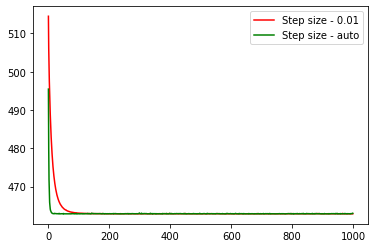

In [49]:
import numpy as np
import matplotlib.pylab as plt

# N = 1000
# K = 10
# X = np.random.randn(N,K)
# y = np.random.randint(0,2,N)

X = np.array(dataset)[:,:-1]
y = np.array(dataset)[:,-1]
print(X.shape)
print(Y.shape)
lr_fixed_step = LogisticRegression(reg_param=0.01, store_iter_loss=True, step_size=0.01)
lr_fixed_step.fit(X, y)

lr_auto_step = LogisticRegression(reg_param=0.01, store_iter_loss=True, step_size='auto')
lr_auto_step.fit(X, y)


plt.plot(np.arange(0, len(lr_fixed_step.iter_loss)), lr_fixed_step.iter_loss, 'r') 
plt.plot(np.arange(0,len(lr_auto_step.iter_loss)), lr_auto_step.iter_loss, 'g')
plt.legend(['Step size - 0.01', 'Step size - auto'])
plt.show()